In [22]:
import os
import librosa
import numpy as np
import pickle
from sklearn import svm
from sklearn.metrics import confusion_matrix, accuracy_score
from sklearn.model_selection import learning_curve, KFold, train_test_split
import seaborn as sns
import matplotlib.pyplot as plt

In [23]:
# Function to augment audio (optional, used for data augmentation)
def augment_audio(y, sr, stretch_factor=1.1, pitch_shift_steps=2):
    """
    Perform time-stretch and pitch-shift augmentation on the audio.
    
    Parameters:
        y (numpy.ndarray): Audio signal
        sr (int): Sample rate of the audio
        stretch_factor (float): Factor to stretch the audio
        pitch_shift_steps (int): Number of semitones to shift the pitch
    
    Returns:
        numpy.ndarray: Augmented audio signal
    """
    try:
        # Time Stretch
        y_stretched = librosa.effects.time_stretch(y, rate=stretch_factor)
        # Pitch Shift
        y_pitch_shifted = librosa.effects.pitch_shift(y_stretched, sr=sr, n_steps=pitch_shift_steps)
        return y_pitch_shifted
    except Exception as e:
        print(f"Error in augmentation: {e}")
        return y  # Return original if error occurs

def extract_features(file_path, n_fft=2048, augment=False):
    try:
        y, sr = librosa.load(file_path, sr=None)
        # Apply augmentation if specified
        if augment:
            y = augment_audio(y, sr)

        # Pad the signal if it's shorter than n_fft
        if len(y) < n_fft:
            padding_length = n_fft - len(y)
            y = np.pad(y, (0, padding_length), mode='constant')  # Pad with zeros

        mfccs = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=13, n_fft=n_fft)
        return np.mean(mfccs.T, axis=0)
    except Exception as e:
        print(f"Error extracting features from {file_path}: {e}")
        return None

def parse_audio_files(input_dir, categories, augment=False, max_files_per_category=4000):
    features, labels = [], []
    for category in categories:
        category_dir = os.path.join(input_dir, category)
        files = [f for f in os.listdir(category_dir) if f.endswith('.wav')]
        print(f"Category '{category}' contains {len(files)} files.")  # Print number of files in each category
        # Limit to max_files_per_category files per category
        files = files[:max_files_per_category]  # Only take the first 100 files

        for file_name in files:
            file_path = os.path.join(category_dir, file_name)
            ext_features = extract_features(file_path, augment=augment)
            if ext_features is not None:
                features.append(ext_features)
                labels.append(category)
            else:
                print(f"Failed to extract features from {file_path}")
    return np.array(features, dtype=np.float32), np.array(labels, dtype=str)


In [24]:
# Verify and set the correct input directory
input_dir = '/kaggle/input/normalized'  # Point to the 'normalized' folder

# List the directories to ensure categories match the available folders
categories_available = os.listdir(input_dir)
print("Available categories:", categories_available)

# Directory setup
categories = ["Anger", "Happiness", "Sadness", "Neutral"]

# Extract features and labels from audio files (with augmentation)
augment = True  # Set to True for augmentation
X, y = parse_audio_files(input_dir, categories, augment=augment, max_files_per_category=4000)


Available categories: ['Surprise', 'Fearful', 'Boredom', 'Neutral', 'Sadness', 'Disgust', 'Happiness', 'Anger']
Category 'Anger' contains 3480 files.
Category 'Happiness' contains 3480 files.
Category 'Sadness' contains 3479 files.
Category 'Neutral' contains 3479 files.


/opt/conda/lib/python3.10/site-packages/librosa/core/spectrum.py:266: UserWarning: n_fft=2048 is too large for input signal of length=1986
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/librosa/core/spectrum.py:266: UserWarning: n_fft=2048 is too large for input signal of length=1805
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/librosa/core/spectrum.py:266: UserWarning: n_fft=2048 is too large for input signal of length=795
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/librosa/core/spectrum.py:266: UserWarning: n_fft=2048 is too large for input signal of length=723
  warnings.warn(


Model trained and saved successfully.
Accuracy Score: 0.6214080459770115


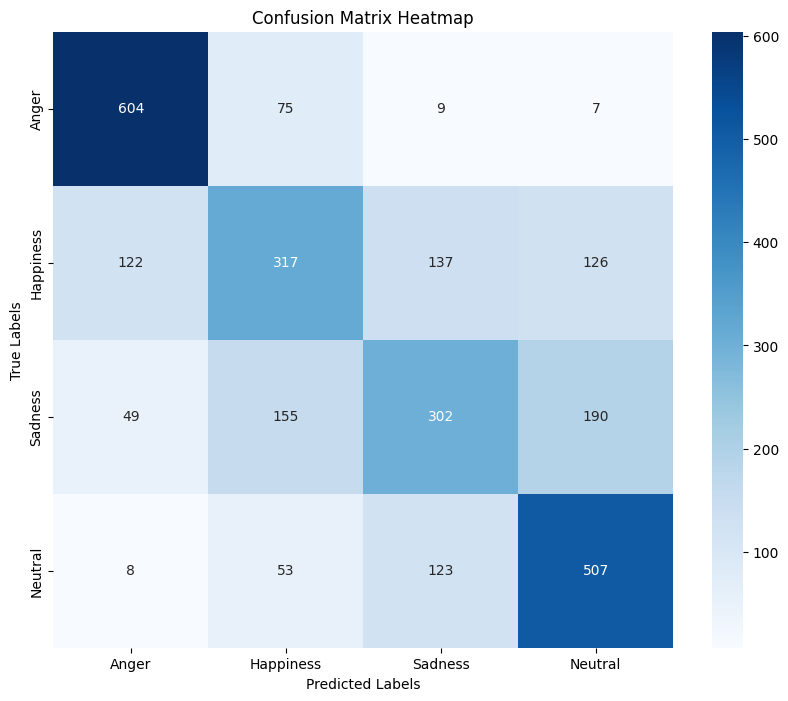

[learning_curve] Training set sizes: [ 890 2894 4898 6902 8907]


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 out of  25 | elapsed: 17.2min finished


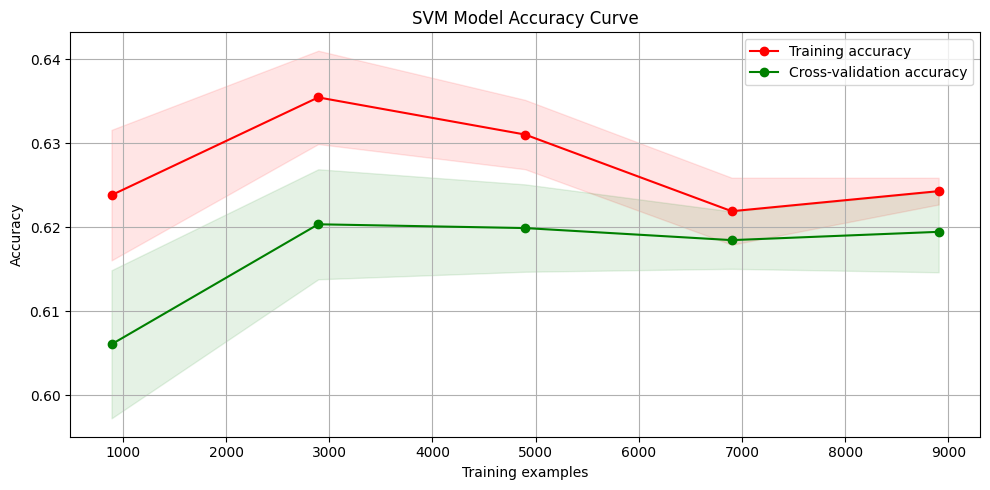

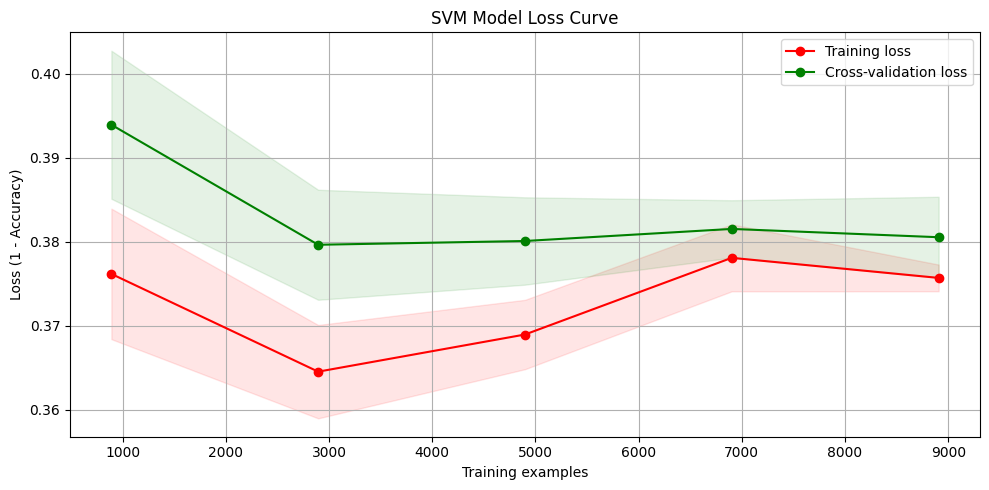

In [25]:
if X.size > 0:
    # Split data into training and test sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    # Initialize and train the SVM model
    clf = svm.SVC(kernel='linear', C=0.1, probability=True)
    clf.fit(X_train, y_train)
    pickle.dump(clf, open('SVM_Model_protocol.sav', 'wb'))

    print("Model trained and saved successfully.")

    # Predict on the test set
    y_pred = clf.predict(X_test)

    # Calculate accuracy score
    accuracy = accuracy_score(y_test, y_pred)
    print("Accuracy Score:", accuracy)

    # Compute confusion matrix
    conf_matrix = confusion_matrix(y_test, y_pred, labels=categories)

    # Plot the confusion matrix heatmap
    plt.figure(figsize=(10, 8))
    sns.heatmap(
        conf_matrix, 
        annot=True, 
        fmt='d', 
        cmap='Blues', 
        xticklabels=categories, 
        yticklabels=categories
    )
    plt.title('Confusion Matrix Heatmap')
    plt.xlabel('Predicted Labels')
    plt.ylabel('True Labels')
    plt.show()

    # Learning Curve Visualization
    seed = 7
    kfold = KFold(n_splits=5, shuffle=True, random_state=seed)

    train_sizes, train_scores, test_scores = learning_curve(
        clf,
        X_train,
        y_train,
        n_jobs=-1,
        cv=kfold,
        train_sizes=np.linspace(.1, 1.0, 5),
        verbose=1
    )

    # Calculate mean and standard deviation for training and test scores
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)

    # Accuracy Graph (First)
    plt.figure(figsize=(10, 5))
    plt.title("SVM Model Accuracy Curve")
    plt.xlabel("Training examples")
    plt.ylabel("Accuracy")
    plt.grid()
    plt.fill_between(train_sizes, train_scores_mean - train_scores_std, train_scores_mean + train_scores_std, alpha=0.1, color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std, test_scores_mean + test_scores_std, alpha=0.1, color="g")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r", label="Training accuracy")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g", label="Cross-validation accuracy")
    plt.legend(loc="best")
    plt.tight_layout()
    plt.show()  # Display the accuracy graph

    # Loss Graph (Second)
    plt.figure(figsize=(10, 5))
    plt.title("SVM Model Loss Curve")
    plt.xlabel("Training examples")
    plt.ylabel("Loss (1 - Accuracy)")
    plt.grid()
    plt.fill_between(train_sizes, 1 - train_scores_mean - train_scores_std, 1 - train_scores_mean + train_scores_std, alpha=0.1, color="r")
    plt.fill_between(train_sizes, 1 - test_scores_mean - test_scores_std, 1 - test_scores_mean + test_scores_std, alpha=0.1, color="g")
    plt.plot(train_sizes, 1 - train_scores_mean, 'o-', color="r", label="Training loss")
    plt.plot(train_sizes, 1 - test_scores_mean, 'o-', color="g", label="Cross-validation loss")
    plt.legend(loc="best")
    plt.tight_layout()
    plt.show()  # Display the loss graph

else:
    print("No valid features extracted for training data.")
